# PCA pipeline

## 1. Libraries and classes, functions

In [79]:
import os, sys
sys.path.append(os.path.abspath('../'))
from src.utils import load_extracted_data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sys.path.append(os.path.abspath('../.private/'))
# if 'my_mpl_styler.py' in os.listdir('../.private/'):
#     import my_mpl_styler

In [2]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

    
def extract_stepwise_statistics(tabular):
    '''
    extract stepwise statistic(mean)
    '''
    param_names = list(tabular.columns)
    for name in tabular.columns:
        if (name in ('time', 'dataset', 'wafer_count', 'file_path')) or (name.startswith('_step')):
            param_names.remove(name)
    step_nums = [int(name.split('_')[2]) for name in tabular.columns if name.startswith('_step')]

    stepwise = pd.concat([
        tabular[param_names].groupby(tabular[f'_step_{step:0>2}']).aggregate('mean').drop(index=-1)
        for step in step_nums], 
        axis=1, 
        keys=step_nums
    ).sort_index()

    stepwise = pd.concat([
        tabular['time'].groupby(tabular['wafer_count']).aggregate('min').drop(index=-1), 
        stepwise
    ], axis=1)
    stepwise['dataset'] = tabular['dataset'].groupby(tabular['wafer_count']).aggregate('min').drop(index=-1)

    return stepwise


class DropColsWithManyNAs(BaseEstimator, TransformerMixin):
    '''
    columns(variables) with too many NAs are dropped
    '''
    def __init__(self, max_na_ratio=0.4):
        self.max_na_ratio = max_na_ratio
    
    def fit(self, X, y=None):
        self._mask_use_cols = np.mean(np.isnan(X), axis=0) <= self.max_na_ratio
        return self

    def transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            result = X[X.columns[self._mask_use_cols]]
        else:
            result = X[:, self._mask_use_cols]
        mask_not_na = np.all(~np.isnan(result), axis=1)
        self._mask_not_na = mask_not_na
        return result
        # return result[mask_not_na]


class NAImmunityDecorator(BaseEstimator, TransformerMixin):
    '''
    decorate model to be immune to arrays with NAs
    '''
    def __init__(self, body):
        self.body = body

    def _get_notna_mask(self, X, y=None):
        # if y is None:
        #     y = np.empty(X.shape[:1])
        mask_not_na = np.all(~np.isnan(X), axis=1) # & ~np.isnan(y)
        return mask_not_na

    def fit(self, X, y=None):
        mask_not_na = self._get_notna_mask(X)
        self.body.fit(X[mask_not_na])
        return self
    
    def transform(self, X, y=None):
        mask_not_na = self._get_notna_mask(X)
        tfmed = self.body.transform(X[mask_not_na])
        result = np.empty(X.shape[:1] + tfmed.shape[1:])
        result[mask_not_na] = tfmed
        result[~mask_not_na] = np.nan
        return result

## 2. POC#1-1
### 2-1. Sketch

In [142]:
extracted_df = load_extracted_data('../../input/CVD_anomaly_detection/machine1.npz')
stepwise = extract_stepwise_statistics(extracted_df)

X = stepwise.drop(columns=['time', 'dataset'])
time = stepwise['time']
ds_assign = stepwise['dataset']

mask_train = stepwise['dataset'] == 0
mask_val = stepwise['dataset'].isin([2, 3])
mask_non_test = mask_train | mask_val
mask_test = ~mask_non_test

model = make_pipeline(
    RobustScaler(with_centering=True),
    PCA(random_state=42)
)
model = NAImmunityDecorator(model)
model = make_pipeline(
    DropColsWithManyNAs(),
    model
)
model.fit(X[mask_train])

Pipeline(steps=[('dropcolswithmanynas', DropColsWithManyNAs()),
                ('naimmunitydecorator',
                 NAImmunityDecorator(body=Pipeline(steps=[('robustscaler',
                                                           RobustScaler()),
                                                          ('pca',
                                                           PCA(random_state=42))])))])

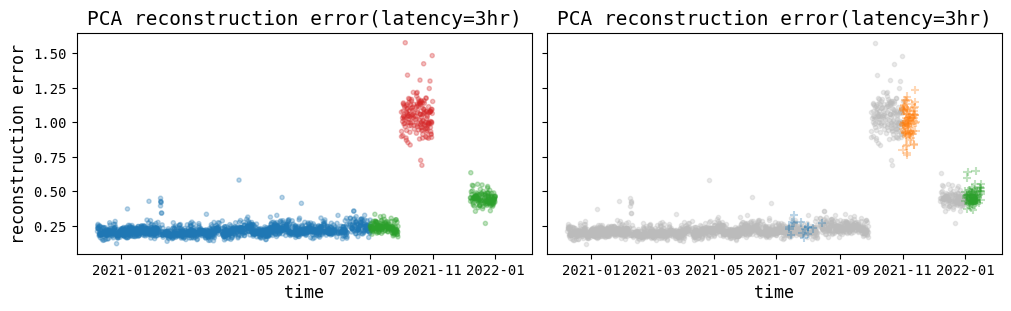

In [153]:
def aggregate_by_time(series, t_ceil, method='mean'):
    return pd.Series(series, index=t_ceil.index).groupby(t_ceil).agg(method)

def transform_by_time(series, t_ceil, method='mean'):
    return pd.Series(series, index=t_ceil.index).groupby(t_ceil).transform(method)

codim = 29
recon_err = np.linalg.norm(model.transform(X)[:, -codim:], axis=-1)
latency = '3h'
t_ceil = time.dt.ceil(latency)

fig, axs = plt.subplots(ncols=2, figsize=(10, 3), sharex=True, sharey=True, layout='constrained')

ax = axs[0]
# ax.scatter(
#     time[mask_non_test], recon_err[mask_non_test], c=ds_assign[mask_non_test],
#     cmap='tab10', vmin=0, vmax=9, alpha=0.3,
#     marker='.',
# )
ax.scatter(
    aggregate_by_time(time[mask_non_test], t_ceil[mask_non_test], 'max'),
    aggregate_by_time(recon_err[mask_non_test], t_ceil[mask_non_test], 'mean'),
    c=aggregate_by_time(ds_assign[mask_non_test], t_ceil[mask_non_test], 'max'),
    cmap='tab10', vmin=0, vmax=9, alpha=0.3,
    marker='.',
)
ax.set_xlabel('time', fontsize=12)
ax.set_ylabel('reconstruction error', fontsize=12)
ax.set_title('PCA reconstruction error(latency=3hr)', fontsize=14)

ax = axs[1]

ax.scatter(
    aggregate_by_time(time[mask_non_test], t_ceil[mask_non_test], 'max'),
    aggregate_by_time(recon_err[mask_non_test], t_ceil[mask_non_test], 'mean'),
    c='#bbbbbb',
    # c=aggregate_by_time(ds_assign[mask_non_test], t_ceil[mask_non_test], 'max'),
    # cmap='tab10', vmin=0, vmax=9
    alpha=0.3,
    marker='.',
)
ax.scatter(
    aggregate_by_time(time[mask_test], t_ceil[mask_test], 'max'),
    aggregate_by_time(recon_err[mask_test], t_ceil[mask_test], 'mean'),
    c=aggregate_by_time(ds_assign[mask_test], t_ceil[mask_test], 'max'),
    cmap='tab10', vmin=4, vmax=13, alpha=0.3,
    marker='+',
)
ax.set_xlabel('time', fontsize=12)
ax.set_title('PCA reconstruction error(latency=3hr)', fontsize=14)

plt.show(); plt.close()

## 2-2. Hyperparameter selection

In [143]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score

latency = '3h'
t_ceil = time.dt.ceil(latency)
val_scores = []
test_scores = []

n_wafer_per_block_train = time[mask_non_test].groupby(t_ceil[mask_non_test]).agg('count')
n_wafer_per_block_test = time[mask_test].groupby(t_ceil[mask_test]).agg('count')

for codim in range(1, X.shape[1]):
    recon_err = np.linalg.norm(model.transform(X)[:, -codim:], axis=-1)

    train_data = aggregate_by_time(recon_err[mask_non_test], t_ceil[mask_non_test], 'mean')
    train_label = (aggregate_by_time(ds_assign[mask_non_test], t_ceil[mask_non_test], 'max') > 2).astype(int)
    mask_notna_train = train_data.notna()
    train_data, train_label = train_data.to_frame()[mask_notna_train], train_label[mask_notna_train]

    test_data = aggregate_by_time(recon_err[mask_test], t_ceil[mask_test], 'mean')
    test_label = (aggregate_by_time(ds_assign[mask_test], t_ceil[mask_test], 'max') == 5).astype(int)
    mask_notna_test = test_data.notna()
    test_data, test_label = test_data.to_frame()[mask_notna_test], test_label[mask_notna_test]

    log_reg = LogisticRegression()
    log_reg.fit(
        train_data, train_label, 
        sample_weight=1/train_label.groupby(train_label).transform('count')
    )
    val_scores.append(1e2* f1_score(train_label, log_reg.predict(train_data), sample_weight=n_wafer_per_block_train[mask_notna_train]))
    test_scores.append(1e2* f1_score(test_label, log_reg.predict(test_data), sample_weight=n_wafer_per_block_test[mask_notna_test]))

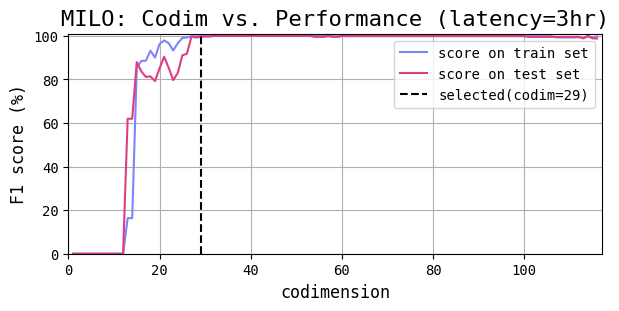

99.53488372093024


In [144]:
optimal_idx = np.argmax(val_scores)+1

plt.subplots(figsize=(6, 3), layout='constrained')
plt.plot(
    np.arange(1, X.shape[1]), val_scores,
    label='score on train set'
)
plt.plot(
    np.arange(1, X.shape[1]), test_scores,
    label='score on test set'
)
plt.vlines(
    x=optimal_idx, ymin=0, ymax=100, color='black', linestyles='--', 
    label=f'selected(codim={optimal_idx})'
)

plt.legend()
plt.grid()
plt.xlim(0, X.shape[1]); plt.xlabel('codimension', fontsize=12)
plt.ylim(0, 101); plt.ylabel('F1 score (%)', fontsize=12)
plt.title('MILO: Codim vs. Performance (latency=3hr)', fontsize=16)
plt.show(); plt.close()
print(test_scores[optimal_idx-1])

## 3. POC#1-2
### 3-1. Sketch

In [155]:
extracted_df = load_extracted_data('../../input/CVD_anomaly_detection/machine2.npz')
stepwise = extract_stepwise_statistics(extracted_df)

X = stepwise.drop(columns=['time', 'dataset']+[el for el in stepwise.columns if el[1] in ['CH PERIODIC INTERVAL', 'CH STEP TIME']])
time = stepwise['time']
ds_assign = stepwise['dataset']

mask_train = stepwise['dataset'] == 0
mask_val = stepwise['dataset'].isin([2, 3])
mask_non_test = mask_train | mask_val
mask_test = ~mask_non_test

model = make_pipeline(
    RobustScaler(with_centering=True),
    PCA(random_state=42)
)
model = NAImmunityDecorator(model)
model = make_pipeline(
    DropColsWithManyNAs(),
    model
)
model.fit(X[mask_train])

Pipeline(steps=[('dropcolswithmanynas', DropColsWithManyNAs()),
                ('naimmunitydecorator',
                 NAImmunityDecorator(body=Pipeline(steps=[('robustscaler',
                                                           RobustScaler()),
                                                          ('pca',
                                                           PCA(random_state=42))])))])

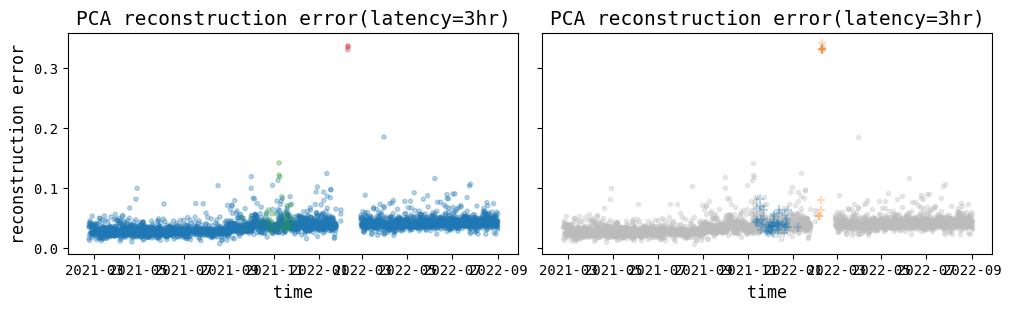

In [157]:
codim = 42

recon_err = np.linalg.norm(model.transform(X)[:, -codim:], axis=-1)
latency = '3h'
t_ceil = time.dt.ceil(latency)
fig, axs = plt.subplots(ncols=2, figsize=(10, 3), sharex=True, sharey=True, layout='constrained')

ax = axs[0]
# ax.scatter(
#     time[mask_non_test], recon_err[mask_non_test], c=ds_assign[mask_non_test],
#     cmap='tab10', vmin=0, vmax=9, alpha=0.3,
#     marker='.',
# )
ax.scatter(
    aggregate_by_time(time[mask_non_test], t_ceil[mask_non_test], 'max'),
    aggregate_by_time(recon_err[mask_non_test], t_ceil[mask_non_test], 'mean'),
    c=aggregate_by_time(ds_assign[mask_non_test], t_ceil[mask_non_test], 'max'),
    cmap='tab10', vmin=0, vmax=9, alpha=0.3,
    marker='.',
)
ax.set_xlabel('time', fontsize=12)
ax.set_ylabel('reconstruction error', fontsize=12)
ax.set_title('PCA reconstruction error(latency=3hr)', fontsize=14)

ax = axs[1]

ax.scatter(
    aggregate_by_time(time[mask_non_test], t_ceil[mask_non_test], 'max'),
    aggregate_by_time(recon_err[mask_non_test], t_ceil[mask_non_test], 'mean'),
    c='#bbbbbb',
    # c=aggregate_by_time(ds_assign[mask_non_test], t_ceil[mask_non_test], 'max'),
    # cmap='tab10', vmin=0, vmax=9
    alpha=0.3,
    marker='.',
)
ax.scatter(
    aggregate_by_time(time[mask_test], t_ceil[mask_test], 'max'),
    aggregate_by_time(recon_err[mask_test], t_ceil[mask_test], 'mean'),
    c=aggregate_by_time(ds_assign[mask_test], t_ceil[mask_test], 'max'),
    cmap='tab10', vmin=4, vmax=13, alpha=0.3,
    marker='+',
)
ax.set_xlabel('time', fontsize=12)
ax.set_title('PCA reconstruction error(latency=3hr)', fontsize=14)

plt.show(); plt.close()

## 3-2. Hyperparamter selection

In [133]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score

latency = '3h'
t_ceil = time.dt.ceil(latency)
val_scores = []
test_scores = []

n_wafer_per_block_train = time[mask_non_test].groupby(t_ceil[mask_non_test]).agg('count')
n_wafer_per_block_test = time[mask_test].groupby(t_ceil[mask_test]).agg('count')

for codim in range(1, X.shape[1]):
    recon_err = np.linalg.norm(model.transform(X)[:, -codim:], axis=-1)

    train_data = aggregate_by_time(recon_err[mask_non_test], t_ceil[mask_non_test], 'mean')
    train_label = (aggregate_by_time(ds_assign[mask_non_test], t_ceil[mask_non_test], 'max') > 2).astype(int)
    mask_notna_train = train_data.notna()
    train_data, train_label = train_data.to_frame()[mask_notna_train], train_label[mask_notna_train]

    test_data = aggregate_by_time(recon_err[mask_test], t_ceil[mask_test], 'mean')
    test_label = (aggregate_by_time(ds_assign[mask_test], t_ceil[mask_test], 'max') == 5).astype(int)
    mask_notna_test = test_data.notna()
    test_data, test_label = test_data.to_frame()[mask_notna_test], test_label[mask_notna_test]

    log_reg = LogisticRegression()
    log_reg.fit(
        train_data, train_label, 
        sample_weight=1/train_label.groupby(train_label).transform('count')
    )
    val_scores.append(1e2* f1_score(train_label, log_reg.predict(train_data), sample_weight=n_wafer_per_block_train[mask_notna_train]))
    test_scores.append(1e2* f1_score(test_label, log_reg.predict(test_data), sample_weight=n_wafer_per_block_test[mask_notna_test]))

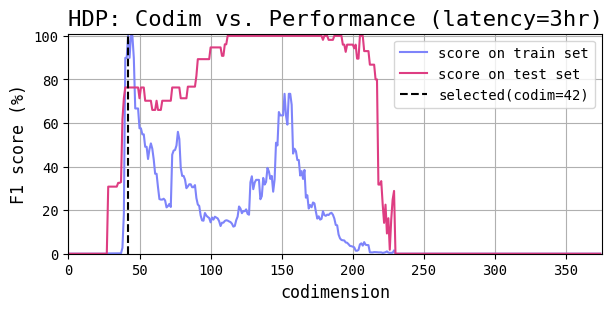

76.30057803468209


In [141]:
optimal_idx = np.argmax(val_scores)+1

plt.subplots(figsize=(6, 3), layout='constrained')
plt.plot(
    np.arange(1, X.shape[1]), val_scores,
    label='score on train set'
)
plt.plot(
    np.arange(1, X.shape[1]), test_scores,
    label='score on test set'
)
plt.vlines(
    x=optimal_idx, ymin=0, ymax=100, color='black', linestyles='--', 
    label=f'selected(codim={optimal_idx})'
)

plt.legend()
plt.grid()
plt.xlim(0, X.shape[1]); plt.xlabel('codimension', fontsize=12)
plt.ylim(0, 101); plt.ylabel('F1 score (%)', fontsize=12)
plt.title('HDP: Codim vs. Performance (latency=3hr)', fontsize=16)
plt.show(); plt.close()
print(test_scores[optimal_idx-1])